# DSCI 100 Group 12 Project Report

# Imports

In [24]:
### Run this cell before continuing.
import random

import altair as alt
import pandas as pd
import sklearn
import numpy as np
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.dummy import DummyClassifier

alt.data_transformers.disable_max_rows()
np.random.seed(1)

# Introduction

## Background

The sinking of the Titanic is one of the most known shipwrecks in history. The widely regarded "unsinkable" Titanic sank after striking an iceberg on April 15, 1912, while on her first voyage. Out of 2224 passengers and crew, 1502 perished because there were not enough lifeboats to go around.

Some people appeared to have higher survival rates than others, despite the fact that survival sometimes involved a certain amount of luck. Based on the provided passenger information, we’d love to explore the dataset and answer the question: what sorts of people were more likely to survive?

## Question

Given a passenger on the Titanic, predict whether they will survive the shipwreck.

## Dataset
The dataset we'll be using is from https://www.kaggle.com/competitions/titanic/data. They provide us with training and test data, but their test data does not provide the ground truth (target variable). Thus, we need to split the training data into train and test split.

The dataset contains a number of features such as the passengers sex, age, cabin number, and more. Our target variable will be the `Survival` feature which is 0 if the passenger did not survive, and 1 if they survived

More info about the dataset and it's features are described below

# Preliminary Exploratory Data Analysis

## Reading the data
> Note: there doesn't seem to be a URL for the dataset. Therefore, we've downloaded the data from Kaggle using the link https://www.kaggle.com/competitions/titanic/data and have moved the csv files into a data directory.

We decided to split our data into 70% training and 30% test making sure to set `random_state=123`

In [25]:
df = pd.read_csv('data/train.csv')
training_data, test_data = train_test_split(df, test_size=0.3, random_state=123, stratify=df['Survived'])
print(f'Original data set size = {df.shape[0]}, train size = {training_data.shape[0]}, test size = {test_data.shape[0]}')
training_data

Original data set size = 891, train size = 623, test size = 268


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
199,200,0,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.0000,NaN,S
468,469,0,3,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q
198,199,1,3,"Madigan, Miss. Margaret ""Maggie""",female,NaN,0,0,370370,7.7500,NaN,Q
574,575,0,3,"Rush, Mr. Alfred George John",male,16.0,0,0,A/4. 20589,8.0500,NaN,S
776,777,0,3,"Tobin, Mr. Roger",male,NaN,0,0,383121,7.7500,F38,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
360,361,0,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,347088,27.9000,NaN,S
669,670,1,1,"Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)",female,NaN,1,0,19996,52.0000,C126,S
245,246,0,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q


## Description of Features
These were taken from https://www.kaggle.com/competitions/titanic/data

| Variable | Definition                                                                                          |
|----------|-----------------------------------------------------------------------------------------------------|
| survival | 1 = survived, 0 = did not survive                                                                   |
| pclass   | Ticket class - a proxy for socio-econimic status 1 = 1st (Upper), 2 = 2nd (Middle), 3 = 3rd (Lower) |
| sex      | Sex (male or female)                                                                                |
| age      | Age in years - is fractional if less than 1 - if it's estimated, it's in the form xx.5              |
| sibsp    | # of siblings / spouses aboard the Titanic                                                          |
| parch    | # of parents / children aboard the Titanic                                                          |
| ticket   | Ticket number                                                                                       |
| fare     | Passenger fare                                                                                      |
| cabin    | Cabin number                                                                                        |
| embarked | Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton                                  |

## Cleaning and wrangling data into a tidy format

The data is already clean and wrangled. Namely
- Each row is a single observation (a single passenger)
- Each column is a single variable
- Each cell contains a single value

Furthermore, the column names are easy to read and use already (no spaces in them) and missing values are represented with `NaN`.

## Summarizing the Data

Here we use `DataFrame::info()` and `DataFrame::describe()` to discover

1. The number of observations for each column and whether we're missing any observations
2. What `Dtype` each column/feature has
3. The mean, std, quartiles, min and max of numerical features

In [26]:
display(training_data.info())
display(training_data.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 199 to 768
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  623 non-null    int64  
 1   Survived     623 non-null    int64  
 2   Pclass       623 non-null    int64  
 3   Name         623 non-null    object 
 4   Sex          623 non-null    object 
 5   Age          501 non-null    float64
 6   SibSp        623 non-null    int64  
 7   Parch        623 non-null    int64  
 8   Ticket       623 non-null    object 
 9   Fare         623 non-null    float64
 10  Cabin        130 non-null    object 
 11  Embarked     622 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 63.3+ KB


None

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,623.000000,623.000000,623.000000,623,623,501.000000,623.000000,623.000000,623,623.000000,130,622
unique,NaN,NaN,NaN,623,2,NaN,NaN,NaN,511,NaN,106,3
top,NaN,NaN,NaN,"Yrois, Miss. Henriette (""Mrs Harbeck"")",male,NaN,NaN,NaN,CA. 2343,NaN,F2,S
freq,NaN,NaN,NaN,1,402,NaN,NaN,NaN,6,NaN,3,444
mean,447.568218,0.383628,2.337079,NaN,NaN,28.941457,0.529695,0.369181,NaN,31.634884,NaN,NaN
std,260.622773,0.486660,0.820961,NaN,NaN,14.147209,1.140599,0.792943,NaN,52.533832,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,438.000000,0.000000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,13.791700,NaN,NaN
75%,687.000000,1.000000,3.000000,NaN,NaN,37.000000,1.000000,0.000000,NaN,30.285400,NaN,NaN


We can see that the features with missing values include `Age`, `Cabin` and `Embarked`. `Cabin` has the most missing number of values, so it may not be useful for our model to learn this feature.

Furthermore, `Name` in our training set is a unique feature for each passenger, so it may not be that useful. We'll expand further on this in the [Methods](#methods) section.

Next, we find the number of observations in each class

In [27]:
display(training_data['Survived'].value_counts())
display(training_data['Survived'].value_counts(normalize=True))

0    384
1    239
Name: Survived, dtype: int64

0    0.616372
1    0.383628
Name: Survived, dtype: float64

We can see there are 379 passengers in the training set that did not survive (roughly 61%) and 244 passengers that survived (roughly 39%).

## Visualizing the Data


For visualizing the data, we'll focus on the following subset of features for now. We explain in the [Features/Variables/Columns](#featuresvariablescolumns) section which predictor variables we'll use and why.

In [28]:
training_data_selected = training_data[training_data["Age"].notnull()].loc[:,["Survived","Sex","Pclass","Age","SibSp","Parch","Fare"]]
training_data_selected

,Survived,Sex,Pclass,Age,SibSp,Parch,Fare
199,0,female,2,24.0,0,0,13.0000
574,0,male,3,16.0,0,0,8.0500
148,0,male,2,36.5,0,2,26.0000
227,0,male,3,20.5,0,0,7.2500
408,0,male,3,21.0,0,0,7.7750
...,...,...,...,...,...,...,...
823,1,female,3,27.0,0,1,12.4750
209,1,male,1,40.0,0,0,31.0000
737,1,male,1,35.0,0,0,512.3292
360,0,male,3,40.0,1,4,27.9000


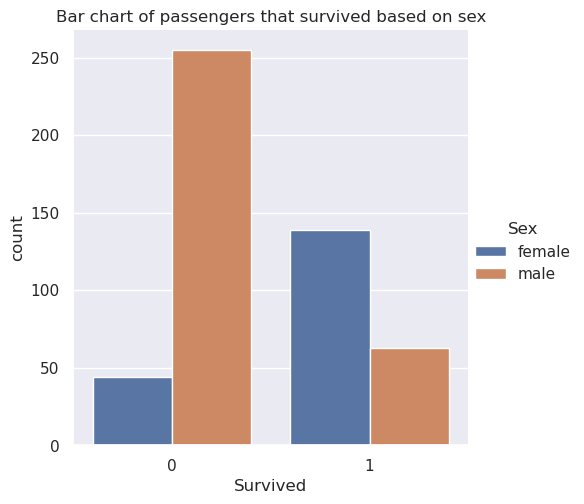

In [29]:
import seaborn as sns
sns.set()
sns.catplot(x = 'Survived', data = training_data_selected, kind = 'count', hue = 'Sex').set(title='Bar chart of passengers that survived based on sex')

From this we can see that more females survived than males since there were more than 125 that survived compared to only about 70 males survived).
Furthermore, more than 200 males did not survive compared to just under 50 females.

After some further research, it seems that the rule for loading the lifeboats were women and children first. If this was the case, we'd expect the percentage of those with younger ages to have survived more than the percentage of adults/older people if children were prioritized. Let's see if this is the case

In [30]:
(
    alt.Chart(training_data_selected)
    .mark_bar()
    .encode(
        x= alt.X("Age", bin=alt.Bin(maxbins=30)),
        y=alt.Y("count()", stack=False),
        color = 'Survived:N'
    )
    .properties(
        width=600,
        height=400
    )
    .facet(
        facet=alt.Facet('Sex', header=alt.Header(labelFontSize=14)),
        title='Histogram of Passenger Age Colored by Survival and Split by Sex'
    )
    .configure_axis(titleFontSize=14)
)


/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.FacetChart(...)

Here we show the distribution of the `Age` variable, using color to separate those who survived and those who didn't. We facet the plot to separate further by sex.

We can see that those with ages less than or equal to 10, regardless of sex, had a much higher survival rate. Furthermore, females seemed to have better chances of surviving than males. This does in fact provide better evidence that there was a rule for loading females and children first in lifeboats.

Next, let's see if the ticket class (a proxy for social economic status) plays a role in the survival rate.

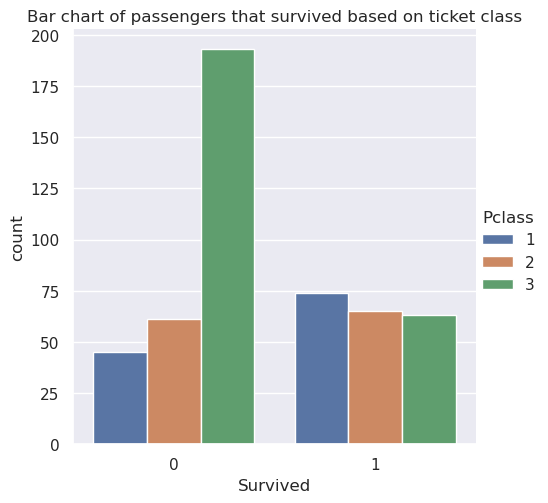

In [31]:
sns.catplot(x = 'Survived', data = training_data_selected, kind = 'count', hue = 'Pclass').set(title='Bar chart of passengers that survived based on ticket class')

From this we can see that most people who failed to survive are from the 3rd class, whereas those that survived the most are from the 1st class.

Next, let's compare the survival rate with the price of the cabin. We create a histogram with the x-axis as the passenger fairs grouped into buckets and the y-axis showing the percentage of passengers in the buckets that survived.

In [32]:
(
    alt.Chart(training_data_selected, title="Normalized Histogram of Fare Price to Percentage of Survivors")
    .mark_bar()
    .encode(
        x= alt.X("Fare", bin=alt.Bin(maxbins=15), title="Fare (£)"),
        y=alt.Y("count()", stack="normalize", axis=alt.Axis(format='%'), title="Percentage of Records"),
        color = 'Survived:N'
    )
)


/opt/conda/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

Interestingly, we can observe that those who paid very cheap fares did not survive as much compared to those who paid more expensive fares greater than or equal to £50. We can see an outlier with a 100% survival rate for those that paid a fare of more than £500.

# Methods and Results

## Procedure for Data Analysis

To conduct our data analysis, first, we'll define the necessary column transformer and pipeline to preprocess our data. We'll use `KNN` to perform the classification and use cross-validation to tune the hyperparameter `n_neighbors` for `KNN` by choosing the value with the highest validation score. We'll use grid search to explore the possible values of `n_neighbors`. We need to do hyperparameter optimization because it's difficult to tell blindly at first what the best hyperparameter value of `n_neighbors` is, and we need to use cross-validation to get a robust approximation of generalization error.

After we obtain our best model, we'll evaluate it against the test set to get the test score. We'll be using the accuracy metric as it's generally a good baseline metric to use first when evaluating models. Because we have some class imbalance, our dummy classifier (baseline) would achieve an accuracy of approximately 61% by always predicting a passenger will not survive. Since there isn't an extreme amount of class imbalance, accuracy won't be a misleading metric.

The reason for choosing `KNN` is because it's a simple classification model that requires few assumptions of what the data should look like and it's fast in terms of training (fit time).

## Features/Variables/Columns

This list may change when we conduct our analysis, but so far these are the features/predictor variables we plan on using and why:

For the first three bullet points (numerical, categorical and binary features), we believe all these features could be useful for our model to decipher and learn interesting patterns about the Titanic passengers, which would be helpful in predicting whether new passengers will survive or not.

- Numerical Features
  - `Age`, `SibSp`, `Parch`, `Fare`
  - Transformation: Scaling, Imputation (`Age` has some missing values)
- Categorical Features
  - `Pclass`, `Embarked`
  - Transformation: OneHotEncoding, Imputation (`Embarked` has some missing values)
- Binary Features
  - `Sex`
  - Transformation: OneHotEncoding (binary)
- Dropped Features
  - `PassengerId` &#8594; because it's unique and just used as the index
  - `Cabin` &#8594; there are too many missing values
  - `Ticket` &#8594; These are all unique for each passenger and our model may not learn any useful patterns based on this
  - `Name` &#8594; again, since this feature is unique, it doesn't provide useful patterns.
- Possible feature engineering if time
  - We could potentially use the `Cabin` feature by extracting the letter prefix
  - For example, if the passenger stays in `Cabin=D26`, we could create a new feature `CabinLevel=D`. This may be useful for our model to learn which level of the boat they belonged in, and we could impute the missing values with some constant.
    - ![img/titanic_diagram.png](https://user-images.githubusercontent.com/49849754/224509673-c01b997a-46db-4e38-b04b-81a27e9c64bd.png)
  - Further details can be found here: https://www.encyclopedia-titanica.org/cabins.html
  - Another feature we could extract is the last name of each passenger. If a model learns that those within the same family survived, then given a passenger with the same last name belonging to the family, it can predict that the passenger survived. However, this may be a complex feature to extract and will require further investigation.

## Creating Training and Test Data

Now let's further split our training and test data into `X_train`, `y_train`, `X_test`, and `y_test`.

In [63]:
X_train = training_data.drop(columns=["Survived"])
X_test = test_data.drop(columns=["Survived"])

y_train = training_data["Survived"]
y_test = test_data["Survived"]

X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
199,200,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.0000,NaN,S
468,469,3,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q
198,199,3,"Madigan, Miss. Margaret ""Maggie""",female,NaN,0,0,370370,7.7500,NaN,Q
574,575,3,"Rush, Mr. Alfred George John",male,16.0,0,0,A/4. 20589,8.0500,NaN,S
776,777,3,"Tobin, Mr. Roger",male,NaN,0,0,383121,7.7500,F38,Q
...,...,...,...,...,...,...,...,...,...,...,...
737,738,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
360,361,3,"Skoog, Mr. Wilhelm",male,40.0,1,4,347088,27.9000,NaN,S
669,670,1,"Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)",female,NaN,1,0,19996,52.0000,C126,S
245,246,1,"Minahan, Dr. William Edward",male,44.0,2,0,19928,90.0000,C78,Q


## Preprocessing

We create a preprocessor performing the transformations to the features we describe above.

In [34]:
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Embarked']
binary_features = ['Sex']
drop_features = ['PassengerId', 'Cabin', 'Ticket', 'Name']
passthrough_features = []
target = "Survived"

# Check that we accounted for all features
assert set([target] + numeric_features + categorical_features + binary_features + passthrough_features + drop_features) == set(training_data.columns)

# Create ColumnTransformer
preprocessor = make_column_transformer(
    (make_pipeline(SimpleImputer(strategy='mean'), StandardScaler()), numeric_features),
    (make_pipeline(SimpleImputer(strategy='constant', fill_value='Missing'), OneHotEncoder(handle_unknown='ignore', sparse=False)), categorical_features),
    (OneHotEncoder(drop='if_binary'), binary_features),
    ('passthrough', passthrough_features),
    ('drop', drop_features)
)

display(preprocessor)
transformed = preprocessor.fit_transform(training_data)
column_names = (
    numeric_features
    + preprocessor.named_transformers_['pipeline-2'].get_feature_names_out().tolist()
    + binary_features
)

print(f'Shape of data: {transformed.shape} of type {type(transformed)}')
pd.DataFrame(transformed, columns=column_names)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Age', 'SibSp', 'Parch', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='Missing',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Pclass', 'Embarked']),
                                ('onehotencoder',
                                 OneHotEncoder(drop='if_binary'), ['Sex']),
                                ('passthrough', 'passthrough', []),
                                ('drop', 'drop',
                                 ['PassengerId', 'Cabin', 'Ticket', 'Name'])])

Shape of data: (623, 12) of type <class 'numpy.ndarray'>


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S,Sex
0,-0.389891,-0.464774,-0.465958,-0.355007,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.000000,-0.464774,-0.465958,-0.455499,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.000000,-0.464774,-0.465958,-0.455023,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,-1.021107,-0.464774,-0.465958,-0.449307,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
4,0.000000,-0.464774,-0.465958,-0.455023,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
618,0.478031,-0.464774,-0.465958,9.157538,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
619,0.872542,0.412663,4.582592,-0.071152,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
620,0.000000,0.412663,-0.465958,0.387969,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
621,1.188150,1.290100,-0.465958,1.111893,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


**Analysis**
- Our numerical features have been scaled and missing values of `Age` have been imputed with the mean value
- Our categorical features have been one hot encoded and missing values of `Embarked` have been imputed with the constant `Missing`
- We dropped the irrelevant features mentioned earlier
- We create a numerical binary column for `Sex`

## Creating a baseline

Next, let's create a baseline using `sklearn DummyClassifier` so we have some base score to compare against.

Note: I'll be using the helper function `mean_std_cross_val_scores` inspired from CPSC 330 to calculate the scores

In [35]:
# Credits to CPSC 330
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [36]:
baseline_model = DummyClassifier(strategy='prior')
base_pipe = make_pipeline(preprocessor, baseline_model)

result = {}
result['baseline'] = mean_std_cross_val_scores(
    base_pipe, X_train, y_train, return_train_score=True, scoring='accuracy', cv=10
)

pd.DataFrame(result).T

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

,fit_time,score_time,test_score,train_score
baseline,0.022 (+/- 0.006),0.010 (+/- 0.001),0.616 (+/- 0.005),0.616 (+/- 0.001)


Here we can see that the dummy classifier achieves an accuracy of 0.608 since it's always predicting that a passenger did not survive (class=0) since that's the most common label. This agrees with the proportion of passengers that did not survive in the training data.

## Model Tuning & Hyperparameter Evaluation

Next, we'll be using multivariate `KNN`  using all the features in our preprocessor and use `GridSearch` to try out different hyperparameter values.

In [37]:
knn_pipe = make_pipeline(preprocessor, KNeighborsClassifier())

parameter_grid = {
    "kneighborsclassifier__n_neighbors": range(1, 100, 5),
}

knn_grid = GridSearchCV(
    estimator=knn_pipe,
    param_grid=parameter_grid,
    cv=10,
    scoring='accuracy',
    return_train_score=True,
)

knn_grid.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare']),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(fill_value='Missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse=False))]),
                                                                         ['Pclass',
                                                                          'Embarked']),
                                                                        ('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['Sex']),
                                                                        ('passthrough',
                                                                         'passthrough',
                                                                         []),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['PassengerId',
                                                                          'Cabin',
                                                                          'Ticket',
                                                                          'Name'])])),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': range(1, 100, 5)},
             return_train_score=True, scoring='accuracy')

In [38]:
print(f'Best {knn_grid.scoring} score: {knn_grid.best_score_}')
print(f'Best hyper-parameters: {knn_grid.best_params_}')
pd.DataFrame(knn_grid.cv_results_)[
    [
        "rank_test_score",
        "mean_test_score",
        "std_test_score",
        "mean_train_score",
        "std_train_score",
        "param_kneighborsclassifier__n_neighbors"
    ]
].set_index("rank_test_score").sort_index().T

Best accuracy score: 0.7959805427547363
Best hyper-parameters: {'kneighborsclassifier__n_neighbors': 16}


rank_test_score,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
mean_test_score,0.795981,0.788018,0.783154,0.776856,0.773528,0.771966,0.763953,0.762417,0.759165,0.744726,0.736713,0.736662,0.735151,0.733513,0.728725,0.728674,0.727087,0.725448,0.722248,0.720661
std_test_score,0.047356,0.047535,0.054583,0.056559,0.040495,0.057476,0.047133,0.048806,0.049153,0.055351,0.042277,0.049842,0.057263,0.051716,0.049141,0.051487,0.052147,0.05053,0.050808,0.051798
mean_train_score,0.81398,0.80988,0.844656,0.802388,0.818618,0.79151,0.98484,0.776528,0.776172,0.759943,0.746207,0.745137,0.754234,0.737113,0.729086,0.730336,0.738718,0.727304,0.725164,0.722667
std_train_score,0.006966,0.007153,0.008473,0.009923,0.008958,0.011771,0.003119,0.010954,0.009362,0.008373,0.008121,0.00884,0.007186,0.006393,0.005365,0.004703,0.005926,0.005359,0.005669,0.004632
param_kneighborsclassifier__n_neighbors,16,21,6,26,11,31,1,36,41,46,61,56,51,71,76,81,66,86,91,96


We can see that the value `k=16` achieved the best mean validation score of approximately 0.796.

The next line of code uses the best model from the grid search using `KNN` to add to our `results` object.

In [39]:
result['multivariate knn optimized'] = mean_std_cross_val_scores(
    knn_grid.best_estimator_, X_train, y_train, return_train_score=True, scoring='accuracy', cv=10
)

pd.DataFrame(result).T

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_outp

,fit_time,score_time,test_score,train_score
baseline,0.022 (+/- 0.006),0.010 (+/- 0.001),0.616 (+/- 0.005),0.616 (+/- 0.001)
multivariate knn optimized,0.037 (+/- 0.017),0.027 (+/- 0.018),0.796 (+/- 0.050),0.814 (+/- 0.007)


Thus, with multivariate KNN with the optimal hyperparameter `n_neighbors=16`, we have achieved a validation score of 0.796 which is a major improvement over our baseline. Our model doesn't seem to be overfitting because the train and test score are low. In the next section below where we visualize our results, we'll plot the hyperparameter values compared to the validation score to confirm if we're underfitting or overfitting.

## KNN Classfication

In order to perform KNN classification with n_neighbors=16, we need to find the best features that influence the survival rate. 

First, we use SelectKBest to find out the p_value and scores of each feature, and to get an optimal fit between bias and variance.

In [107]:
#using SelectKBest to get scores of all feature of the DataFrame

training_data = training_data[["Pclass","Sex","Age","Embarked","SibSp","Parch","Fare","Survived"]].dropna()
X_feature = training_data[["Pclass","Sex","Age","Embarked","SibSp","Parch","Fare"]]
y_feature = training_data["Survived"]
X_feature

,Pclass,Sex,Age,Embarked,SibSp,Parch,Fare
148,2,male,36.5,S,0,2,26.0000
62,1,male,45.0,S,1,0,83.4750
662,1,male,47.0,S,0,0,25.5875
370,1,male,25.0,C,1,0,55.4417
484,1,male,25.0,C,1,0,91.0792
...,...,...,...,...,...,...,...
332,1,male,38.0,S,0,1,153.4625
823,3,female,27.0,S,0,1,12.4750
209,1,male,40.0,C,0,0,31.0000
737,1,male,35.0,C,0,0,512.3292


In order to run SelectKBest, we need to convert categorical and binary features (Embarked,Sex) to float values

In [83]:
X_feature["Embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

In [117]:
#Embarked
X_feature["Embarked"][X_train["Embarked"] == "S"] = 1
X_feature["Embarked"][X_train["Embarked"] == "C"] = 2
X_feature["Embarked"][X_train["Embarked"] == "Q"] = 3

#Sex
X_feature["Sex"][X_train["Sex"]=="male"] = 1
X_feature["Sex"][X_train["Sex"]=="female"]=2

X_feature = X_feature.dropna()
X_feature

/tmp/ipykernel_97766/701033102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_feature["Embarked"][X_train["Embarked"] == "S"] = 1
/tmp/ipykernel_97766/701033102.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_feature["Embarked"][X_train["Embarked"] == "S"] = 1
/tmp/ipykernel_97766/701033102.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_feature["Embarked"][X_train["Embarked"] == "C"] = 2
/tmp/ipykernel_97766/7010331

,Pclass,Sex,Age,Embarked,SibSp,Parch,Fare
148,2,1,36.5,1,0,2,26.0000
62,1,1,45.0,1,1,0,83.4750
662,1,1,47.0,1,0,0,25.5875
370,1,1,25.0,2,1,0,55.4417
484,1,1,25.0,2,1,0,91.0792
...,...,...,...,...,...,...,...
332,1,1,38.0,1,0,1,153.4625
823,3,2,27.0,1,0,1,12.4750
209,1,1,40.0,2,0,0,31.0000
737,1,1,35.0,2,0,0,512.3292


In [86]:
# Perform SelectKBest to get scores of all features

feature = SelectKBest(f_classif,k="all")
feature_fit = feature.fit(X_feature,y_feature)
score = feature_fit.scores_.round(3)
p_values = -np.log10(feature_fit.pvalues_).round(3)

In [88]:
feature_list = list(X_feature.columns.values)
selected_features = feature.get_support([feature_fit])
selected_features

array([0, 1, 2, 3, 4, 5, 6])

In [101]:
# create a temp list to select the features
temp_list=[]
for i in selected_features:
    temp_list.append({'Feature':feature_list[i],'P_value':p_values[i],'Score':score[i]})

# modify the selected feature list
feature_select = pd.DataFrame(temp_list)
feature_select = feature_select.sort_values(by='Score',axis=0,ascending=False,
                                            inplace=False,kind='quicksort',na_position='last')
feature_select = feature_select.set_index('Feature')
feature_select
    

,P_value,Score
Feature,,
Sex,9.705,48.625
Age,2.745,10.208
Embarked,0.470,0.922
SibSp,0.381,0.667
Pclass,0.330,0.530
Fare,0.309,0.477
Parch,0.281,0.408


Now we can see the scores and p-values of the features. We can make a visualization of it

Text(0, 0.5, 'Scores and P Values')

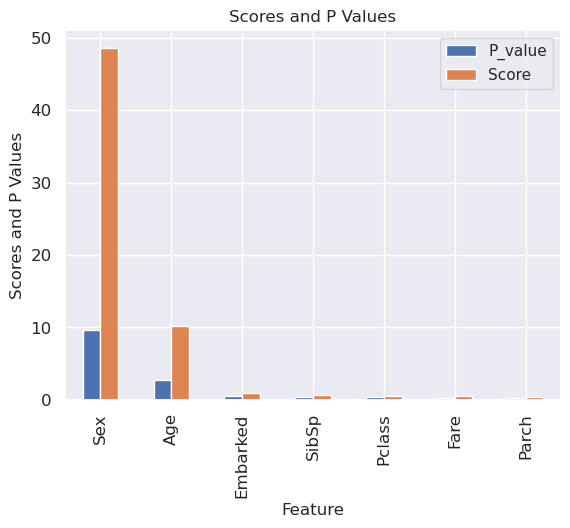

In [106]:
ax = feature_select[['P_value','Score']].plot(kind='bar', title ="Scores and P Values",  legend=True, fontsize=12)
ax.set_xlabel("Feature", fontsize=12)
ax.set_ylabel("Scores and P Values", fontsize=12)
                                               

From the graph showing above, we can see that sex and age has the most influence on whether the person survived. Therefore, we'll use Sex and Age as our main features for the KNN model.

## Predict using KNearstNeighbors


In [131]:
# Specifying model using best nunmber of neighbers
knn=KNeighborsClassifier(n_neighbors=16)
scaler=StandardScaler()

# Setting up training and testing data
X_train=X_feature[["Sex","Age"]]
y_train=training_data["Survived"]

X_test["Sex"][X_test["Sex"]=="male"] = 1
X_test["Sex"][X_test["Sex"]=="female"]=2

test_data=test_data.dropna()

X_test=X_test[["Sex","Age"]]
X_test=X_test.dropna()
y_test=test_data["Survived"]

# Feature scaling
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

#Fitting our model to the training data
knn.fit(X_train,y_train)

scaled_X_test

/tmp/ipykernel_97766/1072960760.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["Sex"][X_test["Sex"]=="male"] = 1
/tmp/ipykernel_97766/1072960760.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["Sex"][X_test["Sex"]=="female"]=2


array([[-0.94280904, -0.3267414 ],
       [-0.94280904, -2.13696114],
       [-0.94280904, -0.90859775],
       [ 1.06066017, -1.10254986],
       [-0.94280904,  0.06116283],
       [-0.94280904,  0.31976565],
       [ 1.06066017, -0.84394704],
       [-0.94280904, -0.45604281],
       [ 1.06066017, -1.16720056],
       [ 1.06066017, -0.71464563],
       [ 1.06066017,  0.06116283],
       [-0.94280904,  0.70766987],
       [ 1.06066017, -0.71464563],
       [-0.94280904,  0.83697128],
       [-0.94280904, -0.3267414 ],
       [ 1.06066017, -0.77929634],
       [-0.94280904, -0.77929634],
       [ 1.06066017, -1.10254986],
       [-0.94280904,  0.44906706],
       [ 1.06066017, -1.6844062 ],
       [-0.94280904,  0.25511494],
       [-0.94280904, -2.22294657],
       [ 1.06066017,  0.64301917],
       [-0.94280904,  0.352091  ],
       [ 1.06066017, -1.74905691],
       [-0.94280904,  0.25511494],
       [ 1.06066017, -0.19743999],
       [-0.94280904,  0.25511494],
       [ 1.06066017,

In [136]:
#Evaluating our model with the testing data
y_pred = knn.predict(scaled_X_test)
y_pred
#pd.DataFrame({'y_Test':y_test, 'y_Pred':y_pred})

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

## Visualizing Results

One way we'll visualize the results is to create a plot comparing the accuracy estimate (validation score) against the number of neighbors. This will better demonstrate why we came to arrive at our optimal parameter value of `n_neighbors`.

We'll also try to create a graph similar to [Fig 5.15](https://python.datasciencebook.ca/classification1.html#:~:text=unscaled_plot%20%2B%20prediction_plot-,Fig.%205.15,-Scatter%20plot%20of) in the textbook, showing the decision boundary of the classifier. This will only work if we trained our model using two features; thus similar to our tutorials/worksheets, we'll train our model once using two features we select and then using all the features described in [Features/Variables/Columns](#featuresvariablescolumns).

Lastly, we'll also create a confusion matrix to get an idea of which types of mistakes our model is making (false negatives or false positives)

# Expected Outcomes and Significance 

Through data analysis with classification, we want to figure out what sort of people were more likely to survive from Titanic shipwrecks. As we classify the training data set, we could find specific variables/features such as “sex” or “ticket class” that influence the likelihood of survival in the Titanic disaster. For example, we would expect that passengers with higher ticket classes or those who lived in higher cabin numbers might have survived more than other groups of people. The impact of these findings can help us better understand which groups of people were more likely to survive than others. This could lead to future questions such as whether these groups shared similarities to survivors of other large-scale boat accidents or natural disasters that also resulted in a large number of deaths. Lastly, we could use these findings and further research methodologies to maximize the number of survivors in case an event like this were to happen again.

# Sources

1. https://www.kaggle.com/competitions/titanic/overview
2. https://www.kaggle.com/code/alexisbcook/titanic-tutorial/notebook
3. https://www.encyclopedia-titanica.org/cabins.html
4. https://titanicfacts.net/titanic-ship/

